In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os
import cv2
from tqdm import tqdm

2025-05-07 00:33:24.993791: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 00:33:24.997416: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 00:33:25.008147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746574405.025927  154962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746574405.030980  154962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746574405.045058  154962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


2025-05-07 00:33:26.750905: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-05-07 00:33:26.750931: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-07 00:33:26.750936: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: alexandre
2025-05-07 00:33:26.750940: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: alexandre
2025-05-07 00:33:26.751213: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 560.35.5
2025-05-07 00:33:26.751239: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 560.35.5
202

In [ ]:

# Loading the dataset
import os
import cv2
from tqdm import tqdm

# Loading the dataset and preparing it for training
train_path = '../dataset_organized/train/'
test_path = '../dataset_organized/test/'
val_path = '../dataset_organized/validation/'

def load_images(path):
    X = []
    y = []
    
    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)
X_val, y_val = load_images(val_path)

classes_names = np.unique(y_train)
num_classes = len(classes_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {classes_names}")

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# One hot encoding the target variable
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)
y_val = to_categorical(y_val_encoded)

# Normalizing the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# # Enhanced Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#       zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=False,
#     fill_mode='nearest',
#     brightness_range=[0.8, 1.2]
# )

# datagen.fit(X_train)


100%|██████████| 17/17 [00:00<00:00, 1544.63it/s]


Number of classes: 6
Class names: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Training set shape: (1768, 150, 150, 3)
Validation set shape: (328, 150, 150, 3)
Test set shape: (431, 150, 150, 3)


In [ ]:

# Define the hypermodel for DenseNet
def build_model(hp):
    # Select DenseNet variant
    densenet_version = hp.Choice('densenet_version', values=['DenseNet121', 'DenseNet169', 'DenseNet201'])
    
    if densenet_version == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    elif densenet_version == 'DenseNet169':
        base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    else:
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Freeze base model layers
    freeze_option = hp.Choice('freeze_option', values=['all', 'partial', 'none'])
    
    if freeze_option == 'all':
        for layer in base_model.layers:
            layer.trainable = False
    elif freeze_option == 'partial':
        # Freeze first 75% of the layers
        total_layers = len(base_model.layers)
        for layer in base_model.layers[:int(total_layers * 0.75)]:
            layer.trainable = False
        for layer in base_model.layers[int(total_layers * 0.75):]:
            layer.trainable = True
    else:  # 'none'
        for layer in base_model.layers:
            layer.trainable = True
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3)
    
    for i in range(num_dense_layers):
        units = hp.Int(f'dense_{i+1}_units', min_value=16, max_value=64, step=16)
        activation = hp.Choice(f'dense_{i+1}_activation', values=['relu', 'tanh', 'elu'])
        
        x = Dense(units=units, activation=activation)(x)
        
        # Add batch normalization option
        use_batch_norm = hp.Boolean(f'batch_norm_{i+1}')
        if use_batch_norm:
            x = BatchNormalization()(x)
            
        dropout_rate = hp.Float(f'dropout_{i+1}_rate', min_value=0.2, max_value=0.6, step=0.1)
        x = Dropout(dropout_rate)(x)
    
    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer == 'adam':
        opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
        opt = SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), momentum=momentum)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per combination
    directory='densenet_tuning',
    project_name='densenet_hyperparameter_tuning'
)

# Print search space summary
tuner.search_space_summary()

# Search for the best hyperparameters
tuner.search(
    # datagen.flow(X_train, y_train, batch_size=32),
    X_train, y_train, 
    steps_per_epoch=len(X_train) // 32,
    epochs=1,
    validation_data=(X_val, y_val)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print detailed information about the optimal hyperparameters
densenet_version = best_hps.get('densenet_version')
freeze_option = best_hps.get('freeze_option')
num_dense_layers = best_hps.get('num_dense_layers')

# Prepare information about dense layers
dense_layers_info = ""
for i in range(num_dense_layers):
    units = best_hps.get(f'dense_{i+1}_units')
    activation = best_hps.get(f'dense_{i+1}_activation')
    batch_norm = best_hps.get(f'batch_norm_{i+1}', False)
    dropout_rate = best_hps.get(f'dropout_{i+1}_rate')
    
    dense_layers_info += f"\n- Layer {i+1}: {units} units, activation: {activation}, "
    dense_layers_info += f"batch normalization: {'Yes' if batch_norm else 'No'}, "
    dense_layers_info += f"dropout rate: {dropout_rate}"

# Prepare optimizer information
optimizer = best_hps.get('optimizer')
learning_rate = best_hps.get('learning_rate')
momentum_info = ""
if optimizer == 'sgd':
    momentum = best_hps.get('momentum')
    momentum_info = f", momentum: {momentum}"

print(f"""
The hyperparameter search is complete. The optimal architecture consists of:

Base model: {densenet_version}
Freeze option: {freeze_option}

Dense layers ({num_dense_layers}):{dense_layers_info}

Optimizer: {optimizer} with learning rate: {learning_rate}{momentum_info}
""")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.summary()

# Train the model with the best hyperparameters
history = model.fit(
    # datagen.flow(X_train, y_train, batch_size=32),
    X_train, y_train,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,  # Train for longer than during search
    validation_data=(X_val, y_val)
)

# Save the best model
model.save('hypertuned_densenet_model.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('densenet_training_history.png')
plt.show()

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Get training and validation metrics from history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print('Training Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)
print('Training Loss:', train_loss)
print('Validation Loss:', val_loss)

# Create confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('densenet_confusion_matrix.png')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes_names))


Reloading Tuner from densenet_tuning/densenet_hyperparameter_tuning/tuner0.json


JSONDecodeError: Extra data: line 1 column 3562 (char 3561)

NameError: name 'history' is not defined

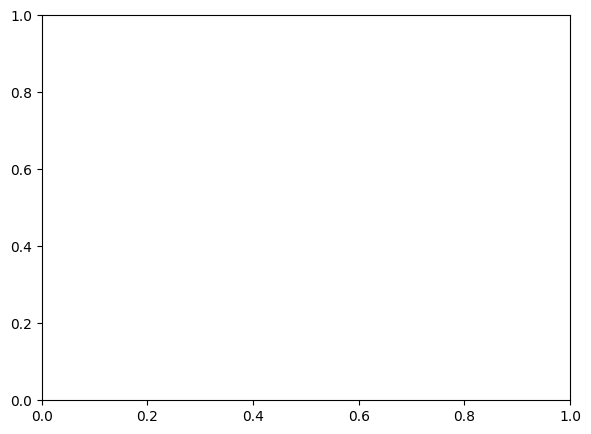

In [12]:

# Save the best model
model.save('hypertuned_densenet_model.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('densenet_training_history.png')
plt.show()

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Get training and validation metrics from history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print('Training Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)
print('Training Loss:', train_loss)
print('Validation Loss:', val_loss)

# Create confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('densenet_confusion_matrix.png')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes_names))


# Load trial

Preparing dataset...
Loading training images...
Loading 287 images from cardboard...


100%|██████████| 287/287 [00:00<00:00, 915.23it/s]


Loading 354 images from glass...


100%|██████████| 354/354 [00:00<00:00, 1089.63it/s]


Loading 286 images from metal...


100%|██████████| 286/286 [00:00<00:00, 1127.99it/s]


Loading 403 images from paper...


100%|██████████| 403/403 [00:00<00:00, 1039.09it/s]


Loading 347 images from plastic...


100%|██████████| 347/347 [00:00<00:00, 1136.02it/s]


Loading 91 images from trash...


100%|██████████| 91/91 [00:00<00:00, 1096.12it/s]


Loading test images...
Loading 70 images from cardboard...


100%|██████████| 70/70 [00:00<00:00, 982.45it/s]


Loading 82 images from glass...


100%|██████████| 82/82 [00:00<00:00, 1107.53it/s]


Loading 68 images from metal...


100%|██████████| 68/68 [00:00<00:00, 1041.69it/s]


Loading 108 images from paper...


100%|██████████| 108/108 [00:00<00:00, 1071.60it/s]


Loading 74 images from plastic...


100%|██████████| 74/74 [00:00<00:00, 1152.94it/s]


Loading 29 images from trash...


100%|██████████| 29/29 [00:00<00:00, 1170.95it/s]


Loading validation images...
Loading 46 images from cardboard...


100%|██████████| 46/46 [00:00<00:00, 1011.70it/s]


Loading 65 images from glass...


100%|██████████| 65/65 [00:00<00:00, 1072.59it/s]


Loading 56 images from metal...


100%|██████████| 56/56 [00:00<00:00, 970.02it/s]


Loading 83 images from paper...


100%|██████████| 83/83 [00:00<00:00, 1062.01it/s]


Loading 61 images from plastic...


100%|██████████| 61/61 [00:00<00:00, 1103.14it/s]


Loading 17 images from trash...


100%|██████████| 17/17 [00:00<00:00, 1062.83it/s]


Number of classes: 6
Class names: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Training set shape: (1768, 150, 150, 3)
Validation set shape: (328, 150, 150, 3)
Test set shape: (431, 150, 150, 3)

Creating model with hardcoded hyperparameters from trial_03...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 156, 156,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,072,502 (26.98 MB)

 Trainable params: 2,091,286 (7.98 MB)

 Non-trainable params: 4,981,216 (19.00 MB)


Training model...
Epoch 1/20


2025-05-07 01:01:06.412429: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 477360000 exceeds 10% of free system memory.


56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 828ms/step - accuracy: 0.3813 - loss: 1.6575 - val_accuracy: 0.1433 - val_loss: 2.6391
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 747ms/step - accuracy: 0.5207 - loss: 1.1950 - val_accuracy: 0.3110 - val_loss: 1.5898
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 696ms/step - accuracy: 0.6193 - loss: 1.0534 - val_accuracy: 0.4848 - val_loss: 1.5998
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 699ms/step - accuracy: 0.6733 - loss: 0.9894 - val_accuracy: 0.3537 - val_loss: 2.0103
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 698ms/step - accuracy: 0.7264 - loss: 0.8275 - val_accuracy: 0.4878 - val_loss: 1.6191
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 700ms/step - accuracy: 0.7222 - loss: 0.8431 - val_accuracy: 0.5854 - val_loss: 1.4115
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 699ms/step - accuracy: 0.7136 - loss: 0.8160 - val_accuracy: 0.5945 - val_loss: 1.4927
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 691ms/step - accuracy: 0.7460 - loss: 0.7390 - val_accuracy: 0.695

Model saved as 'hypertuned_densenet_model.h5'


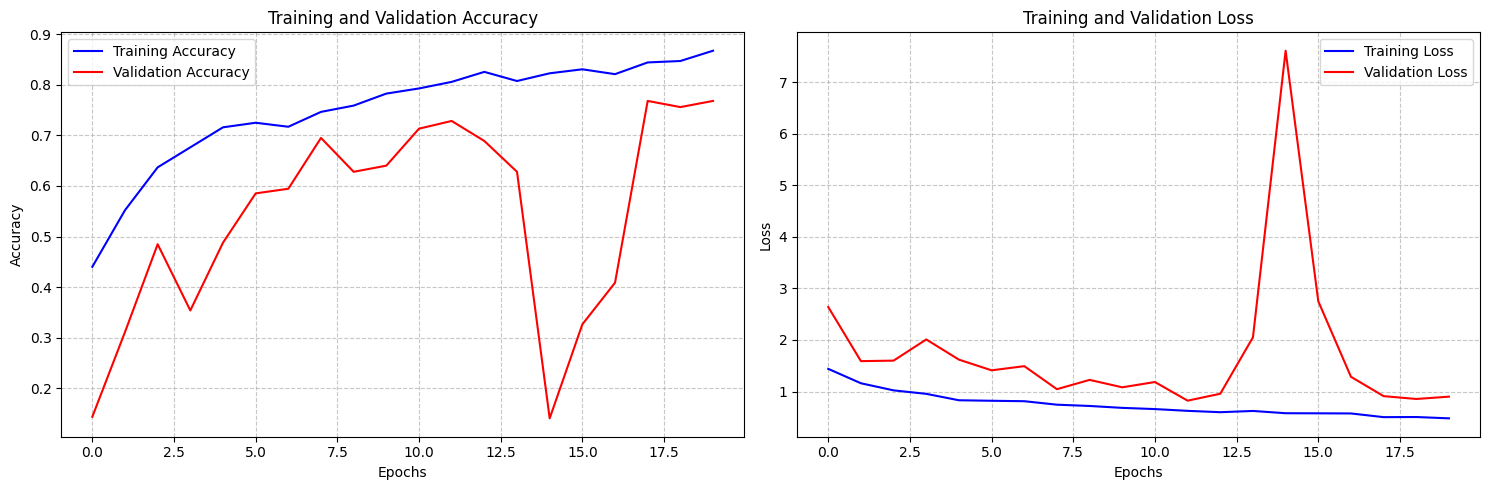

Training plots saved as 'densenet_training_history.png'

Evaluating model on test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.8304 - loss: 0.6339
Test accuracy: 0.7749419808387756
Test loss: 0.8267548680305481

Final metrics:
Training Accuracy: 0.8676470518112183
Validation Accuracy: 0.7682926654815674
Training Loss: 0.4805889427661896
Validation Loss: 0.9011651873588562

Generating confusion matrix...
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step


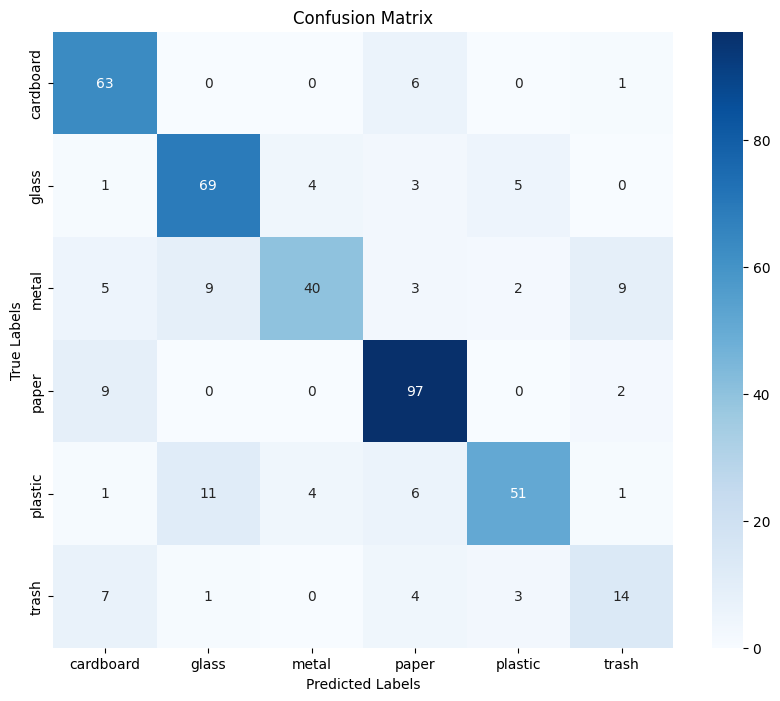

Confusion matrix saved as 'densenet_confusion_matrix.png'

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.73      0.90      0.81        70
       glass       0.77      0.84      0.80        82
       metal       0.83      0.59      0.69        68
       paper       0.82      0.90      0.85       108
     plastic       0.84      0.69      0.76        74
       trash       0.52      0.48      0.50        29

    accuracy                           0.77       431
   macro avg       0.75      0.73      0.73       431
weighted avg       0.78      0.77      0.77       431



In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to load the dataset
def load_images(path):
    X = []
    y = []
    
    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        print(f"Loading {len(files)} images from {folder}...")
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

def prepare_dataset():
    # Path to your dataset
    train_path = '../dataset_organized/train/'
    test_path = '../dataset_organized/test/'
    val_path = '../dataset_organized/validation/'
    
    print("Loading training images...")
    X_train, y_train = load_images(train_path)
    print("Loading test images...")
    X_test, y_test = load_images(test_path)
    print("Loading validation images...")
    X_val, y_val = load_images(val_path)
    
    classes_names = np.unique(y_train)
    num_classes = len(classes_names)
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {classes_names}")
    
    # Encoding the target variable
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    y_val_encoded = label_encoder.transform(y_val)
    
    # One hot encoding the target variable
    y_train = to_categorical(y_train_encoded)
    y_test = to_categorical(y_test_encoded)
    y_val = to_categorical(y_val_encoded)
    
    # Normalizing the images
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, classes_names

def create_densenet_model(num_classes):
    """Create a DenseNet model with hardcoded hyperparameters from trial_03"""
    
    # Base model: DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Freeze option: partial (freeze first 75% of layers)
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * 0.75)]:
        layer.trainable = False
    for layer in base_model.layers[int(total_layers * 0.75):]:
        layer.trainable = True
    
    # Build top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Dense layer 1
    x = Dense(units=32, activation='tanh')(x)
    x = BatchNormalization()(x)  # batch_norm_1: True
    x = Dropout(0.2)(x)  # dropout_1_rate: 0.2
    
    # Dense layer 2
    x = Dense(units=48, activation='elu')(x)
    x = BatchNormalization()(x)  # batch_norm_2: True
    x = Dropout(0.4)(x)  # dropout_2_rate: 0.4
    
    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Optimizer: rmsprop with learning_rate: 0.01
    opt = RMSprop(learning_rate=0.01)
    
    # Compile model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Main execution
def main():
    # Load and prepare the dataset
    print("Preparing dataset...")
    X_train, y_train, X_val, y_val, X_test, y_test, classes_names = prepare_dataset()
    
    # Create the model with hardcoded hyperparameters
    print("\nCreating model with hardcoded hyperparameters from trial_03...")
    model = create_densenet_model(num_classes=len(classes_names))
    
    # Print model summary
    model.summary()
    
    # Train the model
    print("\nTraining model...")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Save the model
    model.save('hypertuned_densenet_model.h5')
    print("Model saved as 'hypertuned_densenet_model.h5'")
    
    # Plotting the training and validation accuracy and loss side by side
    plt.figure(figsize=(15, 5))
    
    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('densenet_training_history.png')
    plt.show()
    print("Training plots saved as 'densenet_training_history.png'")
    
    # Evaluating the model on the test set
    print("\nEvaluating model on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    
    # Get training and validation metrics from history
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    
    print('\nFinal metrics:')
    print('Training Accuracy:', train_acc)
    print('Validation Accuracy:', val_acc)
    print('Training Loss:', train_loss)
    print('Validation Loss:', val_loss)
    
    # Create confusion matrix
    print("\nGenerating confusion matrix...")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes_names, yticklabels=classes_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('densenet_confusion_matrix.png')
    plt.show()
    print("Confusion matrix saved as 'densenet_confusion_matrix.png'")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=classes_names))

if __name__ == "__main__":
    main()